# Hermite FEM in 1-D

For second order BVP, it is enough to use finite elements which are continuous, usually called $C^0$ finite elements. But we can also construct $C^1$ finite elements which have continuity of the solution and its derivatives.

We map each element $\Omega_e = [x_{e - 1 / 2}, x_{e + 1 / 2}]$ to reference
element $[0, 1]$ by
$$
\xi = \frac{x - x_{e - 1 / 2}}{h_e}, \qquad h_e = x_{e + 1 / 2} - x_{e - 1 / 2} 
$$
On this element let us denote
$$
u_0 = u (x_{e - 1 / 2}), \qquad u_1 = u' (x_{e - 1 / 2})
$$
$$
u_2 = u (x_{e + 1 / 2}), \qquad u_3 = u' (x_{e + 1 / 2})
$$
We can approximate the solution by a cubic polynomial
$$
x \in \Omega_e: \qquad u_h (x) = u_h (\xi) = \sum_{j = 0}^3 \phi_j (\xi) u_j
$$
The derivatives are related by
$$
u_h'(x) = \frac{1}{h_e} u_h'(\xi)
$$
Each $\phi_j$ is a cubic polynomial with the properties
$$
\begin{array}{llll}
     \phi_0 (0) = 1, & \phi_0 (1) = 0, & \phi_0' (0) = 0, & \phi_0' (1) = 1\\
     \phi_1 (0) = 0, & \phi_1 (1) = 0, & \phi_1' (0) = h_e, & \phi_1' (1) =
     0\\
     \phi_2 (0) = 0, & \phi_2 (1) = 1, & \phi_2' (0) = 0, & \phi_2' (1) = 0\\
     \phi_3 (0) = 0, & \phi_3 (1) = 0, & \phi_3' (0) = 0, & \phi_3' (1) = h_e
   \end{array}
$$
These conditions ensure that the function and derivative match at the element boundaries. The basis functions are given by
\begin{align*}
  \phi_0 (\xi) & =  1 - 3 \xi^2 + 2 \xi^3 \\
  \phi_1 (\xi) & =  h_e (\xi  - 2 \xi^2 + \xi^3) \\
  \phi_2 (\xi) & =  3 \xi^2  - 2 \xi^3 \\
  \phi_3 (\xi) & =  h_e (-\xi^2 + \xi^3)
\end{align*}
and their derivatives are
\begin{align*}
  \phi_0' (\xi) & =  - 6 \xi + 6 \xi^2\\
  \phi_1' (\xi) & =  h_e  (1 - 4 \xi + 3 \xi^2)\\
  \phi_2' (\xi) & =   6 \xi - 6 \xi^2 \\
  \phi_3' (\xi) & =  h_e  (-2 \xi + 3 \xi^2)
\end{align*}

Import some modules

In [1]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csc_matrix
from scipy.sparse.linalg import spsolve

Let us implement the basis functions.

In [2]:
def phi0(x, h=1.0):
    return 1.0 - 3.0*x**2 + 2*x**3

def dphi0(x, h=1.0):
    return -6.0 * x + 6.0 * x**2

def phi1(x, h=1.0):
    return h * (x - 2.0 * x**2 + x**3)

def dphi1(x, h=1.0):
    return h * (1 - 4.0 * x + 3.0 * x**2)

def phi2(x, h=1.0):
    return 3.0 * x**2 - 2.0 * x**3

def dphi2(x, h=1.0):
    return 6.0 * x - 6.0 * x**2

def phi3(x, h=1.0):
    return h * (-x**2 + x**3)

def dphi3(x, h=1.0):
    return h * (-2.0 * x + 3.0 * x**2)

Plot these basis functions.

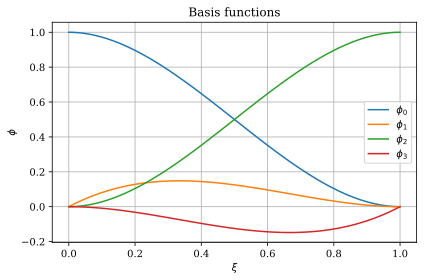

In [3]:
x = np.linspace(0.0, 1.0, 100)
plt.plot(x, phi0(x), label='$\phi_0$')
plt.plot(x, phi1(x), label='$\phi_1$')
plt.plot(x, phi2(x), label='$\phi_2$')
plt.plot(x, phi3(x), label='$\phi_3$')
plt.xlabel('$\\xi$'); plt.ylabel('$\phi$')
plt.title('Basis functions')
plt.legend(); plt.grid('True')

Plot the derivatives of the basis functions.

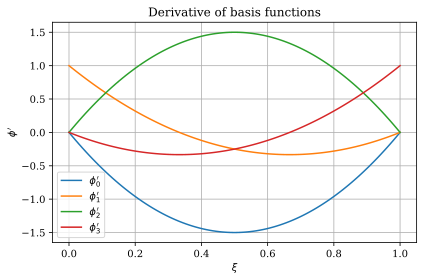

In [4]:
plt.plot(x, dphi0(x), label="$\phi_0'$")
plt.plot(x, dphi1(x), label="$\phi_1'$")
plt.plot(x, dphi2(x), label="$\phi_2'$")
plt.plot(x, dphi3(x), label="$\phi_3'$")
plt.xlabel('$\\xi$'); plt.ylabel("$\phi'$")
plt.title('Derivative of basis functions')
plt.legend(); plt.grid('True')

## Galerkin method

Consider a second order problem of the form
$$
-(a(x)u')' + b(x) u' + c(x) u = f(x)
$$
with boundary conditions
$$
u(0) = 0, \qquad u(1) = 0
$$
The weak formulation is: find $u \in H^1_0(0,1)$ such that
$$
a(u,v) = (f,v), \qquad v \in H^1_0(0,1)
$$
where
$$
a(u,v) = \int_0^1 \left[ a(x) u' v' + b(x) u' v + c(x) u v \right] d x
$$

In [5]:
kw = 20
xmin, xmax = 0.0, 1.0
    
# rhs function
def f(x):
    return (kw)**2 * np.sin(kw*x)

# exact solution, use for bc
def exact_solution(x):
    return x + np.sin(kw*x)

# Returns boundary condition
def boundary_value(x):
    return exact_solution(x)

We now implement the Galerkin method.

In [8]:
def solve_hermite(N):
    k = 3 # Polynomial degree

    # Make grid
    xgrid = np.linspace(xmin,xmax,N+1) # grid
    hgrid = xgrid[1:] - xgrid[0:-1]    # element lengths

    # Build local dof to global dof map
    local_to_global = np.zeros((N,k+1),dtype=int)
    count = 0
    for i in range(N): # element loop
        for j in range(k+1): # dofs inside element
            if i>0 and j==0:
                local_to_global[i,j] = local_to_global[i-1,k-1]
            elif i>0 and j==1:
                local_to_global[i,j] = local_to_global[i-1,k]
            else:
                local_to_global[i,j] = count
                count += 1
            
    # Total no of unknowns, including boundary values
    M = count
    assert(M == 2*(N+1))
    print('Number of unknowns = ', M)
    
    # Gauss-Legendre quadrature points
    Nq = k + 1
    xq,wq = np.polynomial.legendre.leggauss(Nq)
    xq = 0.5*(1 + xq) # transform to [0,1]
    wq = 0.5*wq       # transform to [0,1]
    print('Number of quadrature points =', Nq)
    
    b = np.zeros((M,1))   # rhs vector
    A = lil_matrix((M,M)) # system matrix

    # Assemble matrix and rhs
    print('Assembling ...')
    for n in range(N): # Loop over elements
        e_phi0 = phi0
        e_phi1 = lambda x: phi1(x, hgrid[n])
        e_phi2 = phi2
        e_phi3 = lambda x: phi3(x, hgrid[n])
  
        e_dphi0 = dphi0
        e_dphi1 = lambda x: dphi1(x, hgrid[n])
        e_dphi2 = dphi2
        e_dphi3 = lambda x: dphi3(x, hgrid[n])
        
        shape_funs  = [e_phi0, e_phi1, e_phi2, e_phi3]
        shape_grads = [e_dphi0, e_dphi1, e_dphi2, e_dphi3]

        # Evaluate basis function/gradient at quadrature points
        shape_value = np.zeros((Nq,k+1))
        shape_grad  = np.zeros((Nq,k+1))
        for i in range(k+1):
            shape_value[:,i] = shape_funs[i](xq)
            shape_grad [:,i] = shape_grads[i](xq)
            
        Aloc = np.zeros((k+1,k+1))      # local matrix
        bloc = np.zeros((k+1,1))        # local rhs vector
        xphy = xgrid[n] + xq * hgrid[n] # quad pts in real space
        rhs_values = f(xphy)            # rhs function values
        for i in range(k+1): # Loop over basis functions
            bloc[i] = hgrid[n] * np.sum(rhs_values * shape_value[:,i] * wq)
            for j in range(k+1): # Loop over basis functions
                Aloc[i,j] = np.sum(shape_grad[:,i] * shape_grad[:,j] * wq)/hgrid[n]

        # Add to global matrix and vector
        for i in range(k+1):
            ig = local_to_global[n,i]
            b[ig] += bloc[i]
            for j in range(k+1):
                jg = local_to_global[n,j]
                A[ig,jg] += Aloc[i,j]

    # Apply bc
    print('Applying bcs ...')
    u = np.zeros((M,1))
    u[0]  = boundary_value(xgrid[0])
    u[-2] = boundary_value(xgrid[-1])
    b    -= A@u
    b[0]  = A[0,0]*u[0]
    b[-2] = A[-2,-2]*u[-2]
    A[0,1:]    = 0.0 # first row
    A[1:,0]    = 0.0 # first column
    tmp = A[-2,-2]
    A[-2,:] = 0.0  # last but one row
    A[:,-2] = 0.0  # last but one column
    A[-2,-2] = tmp 
    A = csc_matrix(A) # convert to csc since spsolve needs this

    print('Solving Ax=b ...')
    u = spsolve(A,b)
    
    # Plot solution
    xfine = np.linspace(xmin,xmax,1000)
    plt.plot(xfine,exact_solution(xfine),'k--',label='Exact')
    # Sample fem solution on nu uniform points in each element
    nu = 10 # number of samples in each element
    xu = np.linspace(0,1,nu)
    xfine, ufine = np.empty(0), np.empty(0)
    for n in range(N): # Loop over elements
        e_phi0 = phi0
        e_phi1 = lambda x: phi1(x, hgrid[n])
        e_phi2 = phi2
        e_phi3 = lambda x: phi3(x, hgrid[n])
        shape_funs  = [e_phi0, e_phi1, e_phi2, e_phi3]

        # Create Vandermonde matrix for uniform points
        shape_value = np.zeros((nu,k+1))
        for i in range(k+1):
            shape_value[:,i] = shape_funs[i](xu)
        uloc = u[local_to_global[n,:]] # extract dofs on this element
        values = shape_value @ uloc
        xloc = xgrid[n] + xu * hgrid[n]
        xfine = np.append(xfine, xloc);
        ufine = np.append(ufine, values)
        
    plt.plot(xfine,ufine,'-r',label='Hermite')
    plt.title(str(N)+' elements')
    plt.xlabel('x'); plt.ylabel('u'); plt.grid(True)
    plt.legend()

Now we solve the problem.

Number of unknowns =  14
Number of quadrature points = 4
Assembling ...
Applying bcs ...
Solving Ax=b ...


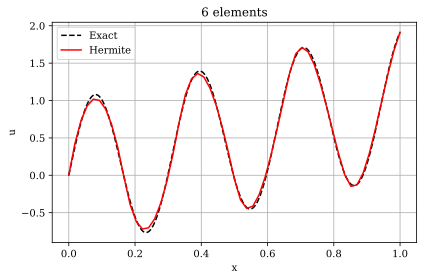

In [10]:
solve_hermite(6)

## TODO
Add computation of error norms and convergence rate for $u, u', u''$.